In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: orden no encontrada


In [1]:
from sklearn.metrics import mean_squared_error, confusion_matrix
import numpy as np
import tensorflow as tf
#physical_devices= tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1], 'GPU')
tf.config.threading.set_inter_op_parallelism_threads(-1)
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import keras_tuner as kt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import reservoirpy as rpy
import lime

2025-06-07 16:12:29.183159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 16:12:29.187077: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-07 16:12:29.197933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749305549.216219    9015 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749305549.221728    9015 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749305549.236079    9015 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
with open('dataset_X_y_sliding_window.npy', 'rb') as f:
    lista_datos = np.load(f, allow_pickle=True)

X_train = lista_datos[0]
X_valid = lista_datos[1]
X_test = lista_datos[2]
y_train = lista_datos[3]
y_valid = lista_datos[4]
y_test = lista_datos[5]

In [3]:
print(y_valid[100:200])

['-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1'
 '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1'
 '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1'
 '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1'
 '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1'
 '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1'
 '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1' '-1'
 '-1' '-1']


In [4]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test)

In [5]:
print(y_valid[100:200])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
X_train.shape

(50448, 100, 62)

<h1> ##################################################
<h1> #####  PRUEBAS RNN  ##############################
<h1> ##################################################

In [14]:
input_shape = X_train.shape[1:]
opt = Adam(0.001)
rnn_model = Sequential()
drp=0.2

rnn_model.add(Input(shape=input_shape))
rnn_model.add(BatchNormalization())
rnn_model.add(LSTM((64), return_sequences=True))
rnn_model.add(LSTM((32)))
rnn_model.add(Dropout(drp))
rnn_model.add(Dense(3, activation='softmax'))
rnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
optimizer=opt,
metrics=["accuracy"])
rnn_model.summary()

I0000 00:00:1747590523.550011   25451 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,475 (146.39 KB)

 Trainable params: 37,411 (146.14 KB)

 Non-trainable params: 64 (256.00 B)

In [15]:
!rm -r ./optimizacion_bayesiana/rnn_optimization*

In [ ]:
def build_model_rnn(hp):
    model = keras.Sequential()
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Input(shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(LSTM((filters_1)))
    model.add(Dropout(dropout_1))
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128, 256])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Dense(units_1, activation='relu'))
    model.add(Dropout(dropout_4))
    
    units_2 = hp.Choice('units_2', values=[16, 32, 64, 128, 256])
    dropout_5 = hp.Choice('dropout_5', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Dense(units_2, activation='relu'))
    model.add(Dropout(dropout_5))
    model.add(Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_rnn,
    objective='val_accuracy',
    max_trials=72,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='rnn_optimization_una_capa'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[stop_early],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Unidades capa densa: {best_hps.get('units_1')}")
print(f"Dropout capa densa: {best_hps.get('dropout_4')}")
print(f"Unidades capa densa: {best_hps.get('units_2')}")
print(f"Dropout capa densa: {best_hps.get('dropout_5')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

Reloading Tuner from optimizacion_bayesiana/rnn_optimization_una_capa/tuner0.json
Mejores hiperparámetros encontrados:
Filtros capa 1: 128
Dropout capa 1: 0.5
Unidades capa densa: 32
Dropout capa densa: 0.4
Unidades capa densa: 256
Dropout capa densa: 0.5
Tasa de aprendizaje: 0.0010981060357238184


/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Accuracy: 0.6354

Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.60      0.53      4943
         joy       0.62      0.57      0.59      5592
     neutral       0.86      0.73      0.79      5640

    accuracy                           0.64     16175
   macro avg       0.65      0.63      0.64     16175
weighted avg       0.66      0.64      0.64     16175



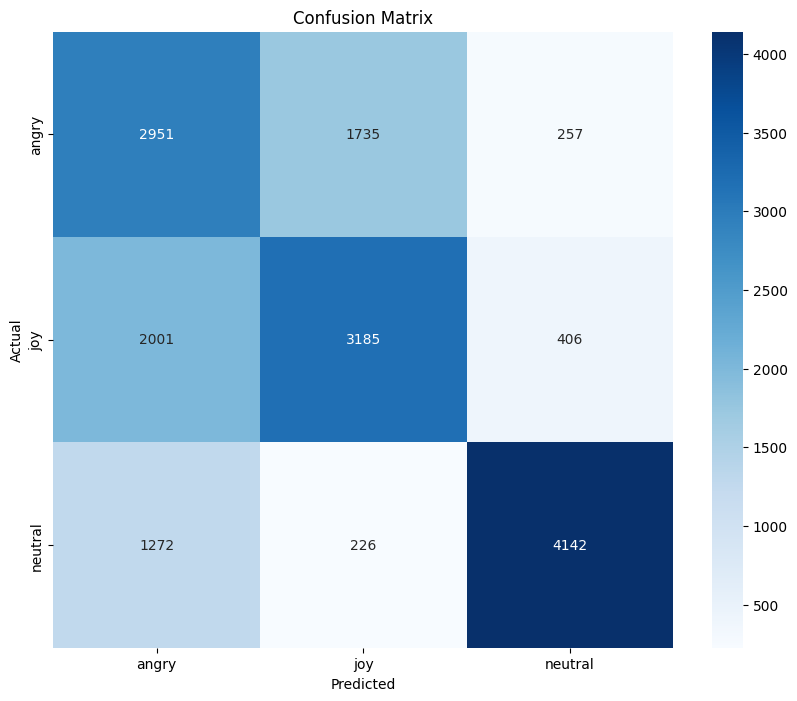

In [117]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def build_model_rnn(hp):
    model = keras.Sequential()
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Input(shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(LSTM((filters_1), return_sequences=True))
    model.add(Dropout(dropout_1))
    
    # Segunda capa convolucional con hiperparámetros ajustables
    filters_2 = hp.Choice('filters_2', values=[16, 32, 64, 128])
    dropout_2 = hp.Choice('dropout_2', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(LSTM((filters_2), return_sequences=True))
    model.add(Dropout(dropout_2))
    
    filters_3 = hp.Choice('filters_3', values=[16, 32, 64, 128])
    dropout_3 = hp.Choice('dropout_3', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(LSTM((filters_3)))
    model.add(Dropout(dropout_3))
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128, 256])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Dense(units_1, activation='relu'))
    model.add(Dropout(dropout_4))
    
    units_2 = hp.Choice('units_2', values=[16, 32, 64, 128, 256])
    dropout_5 = hp.Choice('dropout_5', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Dense(units_2, activation='relu'))
    model.add(Dropout(dropout_5))
    model.add(Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_rnn,
    objective='val_accuracy',
    max_trials=72,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='rnn_optimization_tres_capas'
)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[stop_early],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Filtros capa 2: {best_hps.get('filters_2')}")
print(f"Dropout capa 2: {best_hps.get('dropout_2')}")
print(f"Filtros capa 2: {best_hps.get('filters_3')}")
print(f"Dropout capa 2: {best_hps.get('dropout_3')}")
print(f"Unidades capa densa: {best_hps.get('units_1')}")
print(f"Dropout capa densa: {best_hps.get('dropout_4')}")
print(f"Unidades capa densa: {best_hps.get('units_2')}")
print(f"Dropout capa densa: {best_hps.get('dropout_5')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

I0000 00:00:1748607945.847147   17801 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10532 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
I0000 00:00:1748607945.850991   17801 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10534 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Reloading Tuner from optimizacion_bayesiana/rnn_optimization_tres_capas/tuner0.json
Mejores hiperparámetros encontrados:
Filtros capa 1: 128
Dropout capa 1: 0.7
Filtros capa 2: 128
Dropout capa 2: 0.2
Filtros capa 2: 128
Dropout capa 2: 0.4
Unidades capa densa: 128
Dropout capa densa: 0.4
Unidades capa densa: 16
Dropout capa densa: 0.2
Tasa de aprendizaje: 0.0008382326036905771


/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1748607953.617113   17857 cuda_dnn.cc:529] Loaded cuDNN version 90300


506/506 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

Accuracy: 0.6428

Classification Report:
              precision    recall  f1-score   support

       angry       0.49      0.63      0.55      4943
         joy       0.62      0.54      0.58      5592
     neutral       0.85      0.76      0.80      5640

    accuracy                           0.64     16175
   macro avg       0.66      0.64      0.64     16175
weighted avg       0.66      0.64      0.65     16175



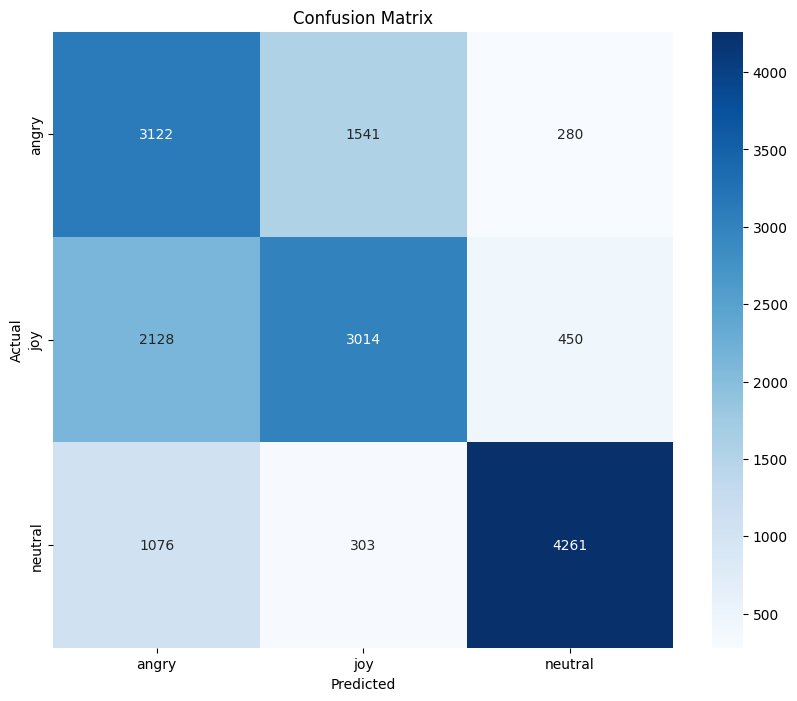

In [9]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def build_model_rnn(hp):
    model = keras.Sequential()
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Input(shape=X_train.shape[1:]))
    model.add(BatchNormalization())
    model.add(LSTM((filters_1), return_sequences=True))
    model.add(Dropout(dropout_1))
    
    # Segunda capa convolucional con hiperparámetros ajustables
    filters_2 = hp.Choice('filters_2', values=[16, 32, 64, 128])
    dropout_2 = hp.Choice('dropout_2', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(LSTM((filters_2)))
    model.add(Dropout(dropout_2))
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128, 256])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Dense(units_1, activation='relu'))
    model.add(Dropout(dropout_4))
    
    units_2 = hp.Choice('units_2', values=[16, 32, 64, 128, 256])
    dropout_5 = hp.Choice('dropout_5', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(Dense(units_2, activation='relu'))
    model.add(Dropout(dropout_5))
    model.add(Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_rnn,
    objective='val_accuracy',
    max_trials=72,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='rnn_optimization_dos_capas'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[stop_early],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Filtros capa 2: {best_hps.get('filters_2')}")
print(f"Dropout capa 2: {best_hps.get('dropout_2')}")
print(f"Unidades capa densa: {best_hps.get('units_1')}")
print(f"Dropout capa densa: {best_hps.get('dropout_4')}")
print(f"Unidades capa densa: {best_hps.get('units_2')}")
print(f"Dropout capa densa: {best_hps.get('dropout_5')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

Reloading Tuner from optimizacion_bayesiana/rnn_optimization_dos_capas/tuner0.json
Mejores hiperparámetros encontrados:
Filtros capa 1: 16
Dropout capa 1: 0.2
Filtros capa 2: 32
Dropout capa 2: 0.2
Unidades capa densa: 256
Dropout capa densa: 0.4
Unidades capa densa: 128
Dropout capa densa: 0.2
Tasa de aprendizaje: 0.004102872358481897


/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Accuracy: 0.6374

Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.71      0.57      4943
         joy       0.65      0.45      0.53      5592
     neutral       0.85      0.77      0.80      5640

    accuracy                           0.64     16175
   macro avg       0.66      0.64      0.64     16175
weighted avg       0.67      0.64      0.64     16175



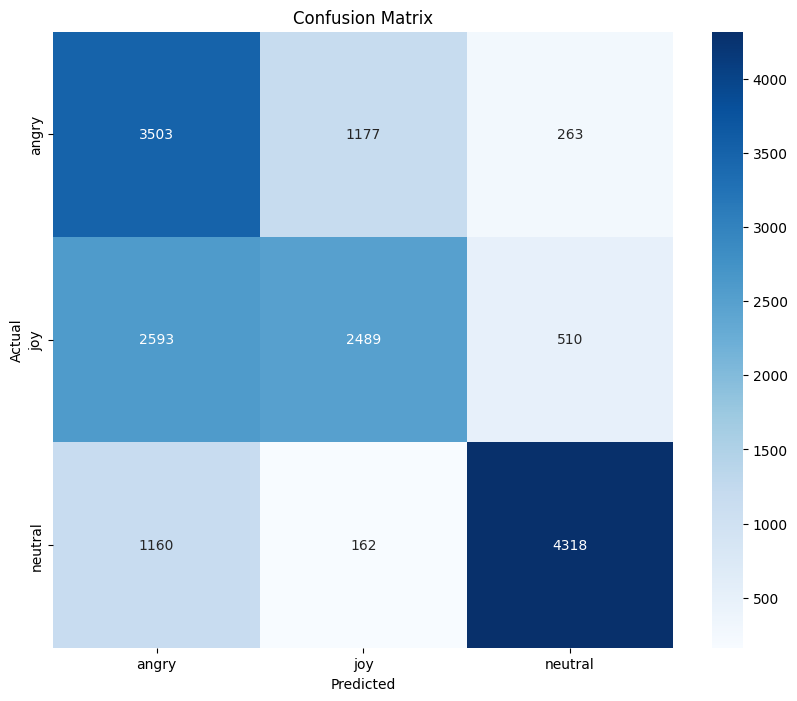

In [115]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [56]:
input_shape = X_train.shape[1:]

rnn_model = Sequential()
rnn_model.add(Input(shape=input_shape))
rnn_model.add(BatchNormalization())
rnn_model.add(LSTM((16), return_sequences=True))
rnn_model.add(Dropout(0.2))
#rnn_model.add(LSTM((32), return_sequences=True))
#rnn_model.add(Dropout(0.5))
rnn_model.add(LSTM((32)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(256, activation='relu'))
rnn_model.add(Dropout(0.4))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(3, activation='softmax'))
rnn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
optimizer=Adam(0.004102872358481897),
metrics=["accuracy"])
rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 100, 62)        │           248 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100, 16)        │         5,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,307 (208.23 KB)

 Trainable params: 53,183 (207.75 KB)

 Non-trainable params: 124 (496.00 B)

In [88]:
model_checkpoint_callback = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)
history = rnn_model.fit(X_train, y_train, batch_size=32,epochs=1000, callbacks=[model_checkpoint_callback], validation_data=(X_valid, y_valid))
res = rnn_model.predict(X_test)
print(model_checkpoint_callback.best)
y_pred = np.argmax(res, axis = 1)

Epoch 1/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.3974 - loss: 1.0603 - val_accuracy: 0.4949 - val_loss: 0.9707
Epoch 2/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6240 - loss: 0.7528 - val_accuracy: 0.5652 - val_loss: 0.8278
Epoch 3/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6939 - loss: 0.6297 - val_accuracy: 0.5896 - val_loss: 0.8305
Epoch 4/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7204 - loss: 0.5908 - val_accuracy: 0.5681 - val_loss: 0.8886
Epoch 5/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7429 - loss: 0.5602 - val_accuracy: 0.5679 - val_loss: 0.9122
Epoch 6/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7529 - loss: 0.5322 - val_accuracy: 0.5944 - val_loss: 0.8909
Epoch 7/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7752 - loss: 0.5093 - val_accuracy: 0.6039 - val_loss: 0.8222
Epoch 8/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - ac

<h1> ##################################################
<h1> #####  PRUEBAS CNN  ##############################
<h1> ##################################################

In [10]:
!rm -r ./optimizacion_bayesiana/cnn_optimization*

In [17]:
X_train = np.expand_dims(X_train, axis=-1)
X_valid = np.expand_dims(X_valid, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
#y_train = np.expand_dims(y_train, axis=-1)
#y_valid = np.expand_dims(y_valid, axis=-1)
#y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
def build_model_cnn(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Input(shape=(100, 62)))
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    kernel_size_1 = hp.Int('kernel_size_1', min_value=2, max_value=5, step=1)
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_1, kernel_size=kernel_size_1, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_1))
    
    # Segunda capa convolucional con hiperparámetros ajustables
    filters_2 = hp.Choice('filters_2', values=[16, 32, 64, 128])
    kernel_size_2 = hp.Int('kernel_size_2', min_value=2, max_value=5, step=1)
    dropout_2 = hp.Choice('dropout_2', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_2, kernel_size=kernel_size_2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_2))
    
    #model_type = hp.Choice("model_type", ["flat", "aver"])
    #with hp.conditional_scope("model_type", ["flat"]):
    #    if model_type == "flat":
    #        model.add(keras.layers.Flatten())
    #with hp.conditional_scope("model_type", ["aver"]):
    #    if model_type == "aver":
    #        model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.GlobalAveragePooling1D())
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128])
    dropout_3 = hp.Choice('dropout_3', values=[0.2, 0.4, 0.5, 0.7])
    units_2 = hp.Choice('units_2', values=[16, 32, 64, 128])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Dense(units_1, activation='relu'))
    model.add(keras.layers.Dropout(dropout_3))
    model.add(keras.layers.Dense(units_2, activation='relu'))
    model.add(keras.layers.Dropout(dropout_4))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_cnn,
    objective='val_loss',
    max_trials=70,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='cnn_optimization_dos_capas'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_valid, y_valid),
    callbacks=[stop_early],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Tamaño kernel capa 1: {best_hps.get('kernel_size_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Filtros capa 2: {best_hps.get('filters_2')}")
print(f"Tamaño kernel capa 2: {best_hps.get('kernel_size_2')}")
print(f"Dropout capa 2: {best_hps.get('dropout_2')}")
#print(f"Tipo de capa para reshape: {best_hps.get('model_type')}")
print(f"Unidades capa densa: {best_hps.get('units_1')}")
print(f"Dropout capa densa: {best_hps.get('dropout_3')}")
print(f"Unidades capa densa: {best_hps.get('units_2')}")
print(f"Dropout capa densa: {best_hps.get('dropout_4')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

Reloading Tuner from optimizacion_bayesiana/cnn_optimization_dos_capas/tuner0.json


I0000 00:00:1748279918.265687   25131 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Mejores hiperparámetros encontrados:
Filtros capa 1: 128
Tamaño kernel capa 1: 2
Dropout capa 1: 0.2
Filtros capa 2: 128
Tamaño kernel capa 2: 4
Dropout capa 2: 0.2
Unidades capa densa: 64
Dropout capa densa: 0.5
Unidades capa densa: 32
Dropout capa densa: 0.5
Tasa de aprendizaje: 0.0030568290538874727


/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
I0000 00:00:1748279920.161109   25402 service.cc:152] XLA service 0x7fe6240046b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748279920.161130   25402 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-26 19:18:40.168014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748279920.207534   25402 cuda_dnn.cc:529] Loaded cuDNN version 90300


110/506 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1748279920.665506   25402 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Accuracy: 0.6770

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.55      0.57      4943
         joy       0.65      0.57      0.61      5592
     neutral       0.77      0.89      0.82      5640

    accuracy                           0.68     16175
   macro avg       0.67      0.67      0.67     16175
weighted avg       0.67      0.68      0.67     16175



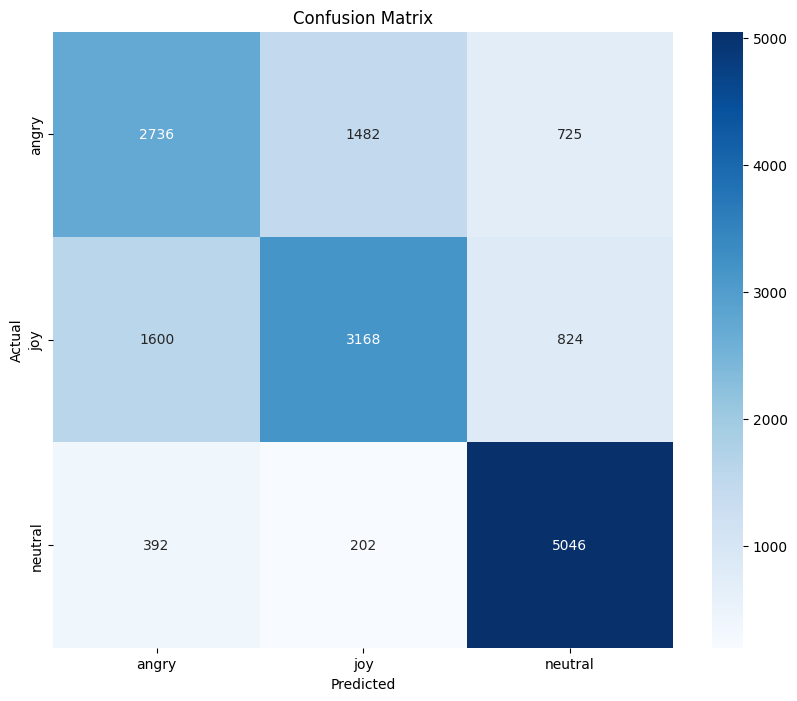

In [9]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def build_model_cnn(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Input(shape=(100, 62)))
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    kernel_size_1 = hp.Int('kernel_size_1', min_value=2, max_value=5, step=1)
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_1, kernel_size=kernel_size_1, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_1))
    
    # Segunda capa convolucional con hiperparámetros ajustables
    filters_2 = hp.Choice('filters_2', values=[16, 32, 64, 128])
    kernel_size_2 = hp.Int('kernel_size_2', min_value=2, max_value=5, step=1)
    dropout_2 = hp.Choice('dropout_2', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_2, kernel_size=kernel_size_2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_2))
    
    # Tercera capa convolucional con hiperparámetros ajustables
    filters_3 = hp.Choice('filters_3', values=[16, 32, 64, 128])
    kernel_size_3 = hp.Int('kernel_size_3', min_value=2, max_value=5, step=1)
    dropout_3 = hp.Choice('dropout_3', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_3, kernel_size=kernel_size_3, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_3))
    
    #model_type = hp.Choice("model_type", ["flat", "aver"])
    #with hp.conditional_scope("model_type", ["flat"]):
    #    if model_type == "flat":
    #        model.add(keras.layers.Flatten())
    #with hp.conditional_scope("model_type", ["aver"]):
    #    if model_type == "aver":
    #        model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.GlobalAveragePooling1D())
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128])
    dropout_3 = hp.Choice('dropout_3', values=[0.2, 0.4, 0.5, 0.7])
    units_2 = hp.Choice('units_2', values=[16, 32, 64, 128])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Dense(units_1, activation='relu'))
    model.add(keras.layers.Dropout(dropout_3))
    model.add(keras.layers.Dense(units_2, activation='relu'))
    model.add(keras.layers.Dropout(dropout_4))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_cnn,
    objective='val_loss',
    max_trials=70,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='cnn_optimization_tres_capas'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_valid, y_valid),
    callbacks=[stop_early],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Tamaño kernel capa 1: {best_hps.get('kernel_size_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Filtros capa 2: {best_hps.get('filters_2')}")
print(f"Tamaño kernel capa 2: {best_hps.get('kernel_size_2')}")
print(f"Dropout capa 2: {best_hps.get('dropout_2')}")
print(f"Filtros capa 3: {best_hps.get('filters_3')}")
print(f"Tamaño kernel capa 3: {best_hps.get('kernel_size_3')}")
print(f"Dropout capa 3: {best_hps.get('dropout_3')}")
#print(f"Tipo de capa para reshape: {best_hps.get('model_type')}")
print(f"Unidades capa densa 1: {best_hps.get('units_1')}")
print(f"Dropout capa densa 1: {best_hps.get('dropout_3')}")
print(f"Unidades capa densa 2 : {best_hps.get('units_2')}")
print(f"Dropout capa densa 2: {best_hps.get('dropout_4')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

Reloading Tuner from optimizacion_bayesiana/cnn_optimization_tres_capas/tuner0.json


2025-06-07 16:12:41.609641: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Mejores hiperparámetros encontrados:
Filtros capa 1: 32
Tamaño kernel capa 1: 2
Dropout capa 1: 0.4
Filtros capa 2: 64
Tamaño kernel capa 2: 4
Dropout capa 2: 0.7
Filtros capa 3: 16
Tamaño kernel capa 3: 2
Dropout capa 3: 0.4
Unidades capa densa 1: 32
Dropout capa densa 1: 0.4
Unidades capa densa 2 : 16
Dropout capa densa 2: 0.4
Tasa de aprendizaje: 0.006128340624363599


/home/ricmarrom/miniconda3/envs/tfm_eeg/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Accuracy: 0.6814

Classification Report:
              precision    recall  f1-score   support

       angry       0.52      0.73      0.61      4943
         joy       0.71      0.49      0.58      5592
     neutral       0.87      0.82      0.85      5640

    accuracy                           0.68     16175
   macro avg       0.70      0.68      0.68     16175
weighted avg       0.71      0.68      0.68     16175



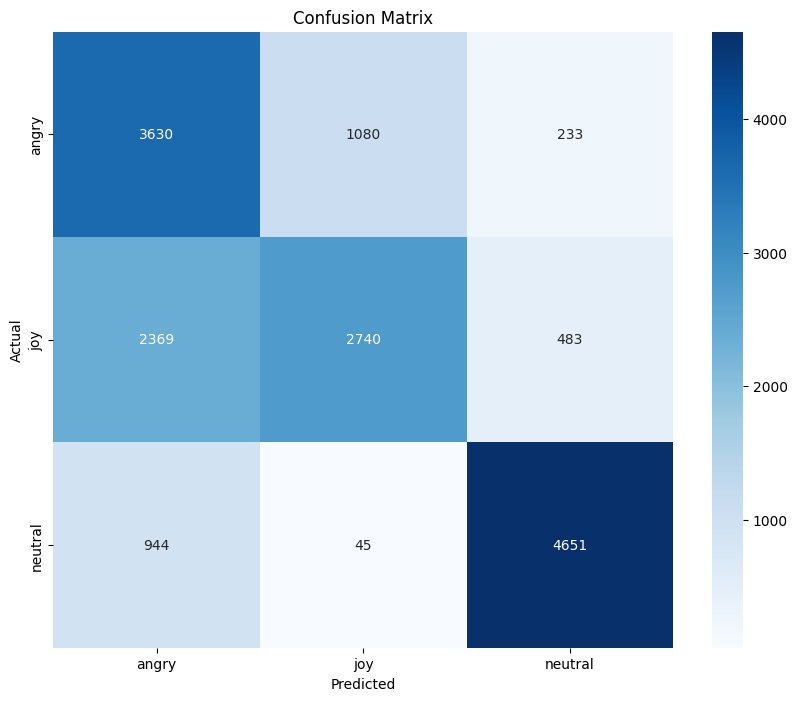

In [8]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
tuner.get_best_models()

[<Sequential name=sequential, built=True>]

In [47]:
input_shape=(100, 62)

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=64, kernel_size=2, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),
    layers.Conv1D(filters=128, kernel_size=2, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.5),
    #layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    #layers.MaxPooling1D(pool_size=2),
    #layers.Dropout(0.7),
    #layers.Flatten(),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    #layers.Dense(32, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(3, activation='softmax') 
])

model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
optimizer=Adam(0.001),
metrics=["accuracy"])
model_cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 100, 64)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 50, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,219 (129.76 KB)

 Trainable params: 33,091 (129.26 KB)

 Non-trainable params: 128 (512.00 B)

In [48]:
model_checkpoint_callback = EarlyStopping(monitor='val_accuracy', mode='max', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)
history = model_cnn.fit(X_train, y_train, batch_size=32,epochs=1000, callbacks=[model_checkpoint_callback], validation_data=(X_valid, y_valid))
res = model_cnn.predict(X_test)
y_pred = np.argmax(res, axis = 1)
print(model_checkpoint_callback.best)

Epoch 1/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.4114 - loss: 1.0532 - val_accuracy: 0.5151 - val_loss: 0.8566
Epoch 2/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6288 - loss: 0.7537 - val_accuracy: 0.5894 - val_loss: 0.7861
Epoch 3/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6919 - loss: 0.6571 - val_accuracy: 0.6248 - val_loss: 0.7746
Epoch 4/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7292 - loss: 0.5893 - val_accuracy: 0.6321 - val_loss: 0.7997
Epoch 5/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7555 - loss: 0.5424 - val_accuracy: 0.6356 - val_loss: 0.8420
Epoch 6/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7829 - loss: 0.4951 - val_accuracy: 0.6542 - val_loss: 0.7880
Epoch 7/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7880 - loss: 0.4765 - val_accuracy: 0.6377 - val_loss: 0.8927
Epoch 8/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7996 

<h1> ##################################################
<h1> #####  PRUEBAS CNN + RNN #########################
<h1> ##################################################

In [159]:
!rm -r ./optimizacion_bayesiana/hbd_optimization

In [ ]:
def build_model_hbd(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Input(shape=(100, 62)))
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    kernel_size_1 = hp.Int('kernel_size_1', min_value=2, max_value=5, step=1)
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_1, kernel_size=kernel_size_1, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_1))
    
    # Segunda capa convolucional con hiperparámetros ajustables
    filters_2 = hp.Choice('filters_2', values=[16, 32, 64, 128])
    kernel_size_2 = hp.Int('kernel_size_2', min_value=2, max_value=5, step=1)
    dropout_2 = hp.Choice('dropout_2', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_2, kernel_size=kernel_size_2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_2))
    
    # Primera capa recurrente con hiperparámetros ajustables
    filters_3 = hp.Choice('filters_3', values=[16, 32, 64, 128])
    dropout_3 = hp.Choice('dropout_3', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(BatchNormalization())
    model.add(LSTM((filters_3), return_sequences=True))
    model.add(Dropout(dropout_3))
    
    # Segunda capa recurrente con hiperparámetros ajustables
    filters_4 = hp.Choice('filters_4', values=[16, 32, 64, 128])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(LSTM((filters_4)))
    model.add(Dropout(dropout_4))
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128, 256])
    dropout_5 = hp.Choice('dropout_5', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Dense(units_1, activation='relu'))
    model.add(keras.layers.Dropout(dropout_5))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_hbd,
    objective='val_loss',
    max_trials=70,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='hbd_optimization_una_densa'
)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Tamaño kernel capa 1: {best_hps.get('kernel_size_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Filtros capa 2: {best_hps.get('filters_2')}")
print(f"Tamaño kernel capa 2: {best_hps.get('kernel_size_2')}")
print(f"Dropout capa 2: {best_hps.get('dropout_2')}")
print(f"Neuronas capa 3: {best_hps.get('filters_3')}")
print(f"Dropout capa 3: {best_hps.get('dropout_3')}")
print(f"Neuronas capa 4: {best_hps.get('filters_4')}")
print(f"Dropout capa 4: {best_hps.get('dropout_4')}")
print(f"Unidades capa densa: {best_hps.get('units_1')}")
print(f"Dropout capa densa: {best_hps.get('dropout_5')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

Reloading Tuner from optimizacion_bayesiana/hbd_optimization_una_densa/tuner0.json
Mejores hiperparámetros encontrados:
Filtros capa 1: 128
Tamaño kernel capa 1: 3
Dropout capa 1: 0.4
Filtros capa 2: 16
Tamaño kernel capa 2: 4
Dropout capa 2: 0.5
Neuronas capa 3: 64
Dropout capa 3: 0.2
Neuronas capa 4: 32
Dropout capa 4: 0.4
Unidades capa densa: 64
Dropout capa densa: 0.4
Tasa de aprendizaje: 0.0022432251370050334


/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Accuracy: 0.6367

Classification Report:
              precision    recall  f1-score   support

       angry       0.47      0.62      0.54      4943
         joy       0.63      0.50      0.56      5592
     neutral       0.83      0.79      0.81      5640

    accuracy                           0.64     16175
   macro avg       0.65      0.64      0.64     16175
weighted avg       0.65      0.64      0.64     16175



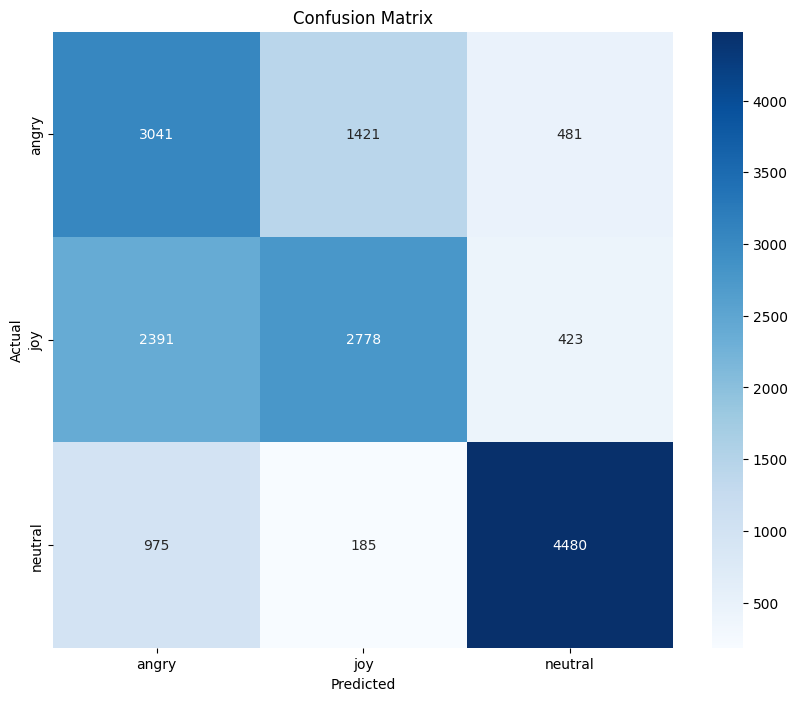

In [15]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def build_model_hbd(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Input(shape=(100, 62)))
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    kernel_size_1 = hp.Int('kernel_size_1', min_value=2, max_value=5, step=1)
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_1, kernel_size=kernel_size_1, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_1))
    
    # Segunda capa convolucional con hiperparámetros ajustables
    filters_2 = hp.Choice('filters_2', values=[16, 32, 64, 128])
    kernel_size_2 = hp.Int('kernel_size_2', min_value=2, max_value=5, step=1)
    dropout_2 = hp.Choice('dropout_2', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_2, kernel_size=kernel_size_2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_2))
    
    # Primera capa recurrente con hiperparámetros ajustables
    filters_3 = hp.Choice('filters_3', values=[16, 32, 64, 128])
    dropout_3 = hp.Choice('dropout_3', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(BatchNormalization())
    model.add(LSTM((filters_3), return_sequences=True))
    model.add(Dropout(dropout_3))
    
    # Segunda capa recurrente con hiperparámetros ajustables
    filters_4 = hp.Choice('filters_4', values=[16, 32, 64, 128])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(LSTM((filters_4)))
    model.add(Dropout(dropout_4))
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128, 256])
    dropout_5 = hp.Choice('dropout_5', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Dense(units_1, activation='relu'))
    model.add(keras.layers.Dropout(dropout_5))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Capa densa con hiperparámetros ajustables
    units_2 = hp.Choice('units_2', values=[16, 32, 64, 128, 256])
    dropout_6 = hp.Choice('dropout_6', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Dense(units_2, activation='relu'))
    model.add(keras.layers.Dropout(dropout_6))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_hbd,
    objective='val_accuracy',
    max_trials=70,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='hbd_optimization_dos_densas'
)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Tamaño kernel capa 1: {best_hps.get('kernel_size_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Filtros capa 2: {best_hps.get('filters_2')}")
print(f"Tamaño kernel capa 2: {best_hps.get('kernel_size_2')}")
print(f"Dropout capa 2: {best_hps.get('dropout_2')}")
print(f"Neuronas capa 3: {best_hps.get('filters_3')}")
print(f"Dropout capa 3: {best_hps.get('dropout_3')}")
print(f"Neuronas capa 4: {best_hps.get('filters_4')}")
print(f"Dropout capa 4: {best_hps.get('dropout_4')}")
print(f"Unidades capa densa 1: {best_hps.get('units_1')}")
print(f"Dropout capa densa 1: {best_hps.get('dropout_5')}")
print(f"Unidades capa densa 2: {best_hps.get('units_2')}")
print(f"Dropout capa densa 2: {best_hps.get('dropout_6')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

Trial 70 Complete [00h 07m 05s]
val_accuracy: 0.6563279628753662

Best val_accuracy So Far: 0.6563279628753662
Total elapsed time: 2d 10h 33m 54s
Mejores hiperparámetros encontrados:
Filtros capa 1: 128
Tamaño kernel capa 1: 2
Dropout capa 1: 0.7
Filtros capa 2: 128
Tamaño kernel capa 2: 5
Dropout capa 2: 0.2
Neuronas capa 3: 16
Dropout capa 3: 0.7
Neuronas capa 4: 128
Dropout capa 4: 0.2
Unidades capa densa 1: 64
Dropout capa densa 1: 0.7
Unidades capa densa 2: 128
Dropout capa densa 2: 0.4
Tasa de aprendizaje: 0.0005752500077351986


/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Accuracy: 0.6519

Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.56      0.55      4943
         joy       0.63      0.60      0.62      5592
     neutral       0.75      0.78      0.77      5640

    accuracy                           0.65     16175
   macro avg       0.65      0.65      0.65     16175
weighted avg       0.65      0.65      0.65     16175



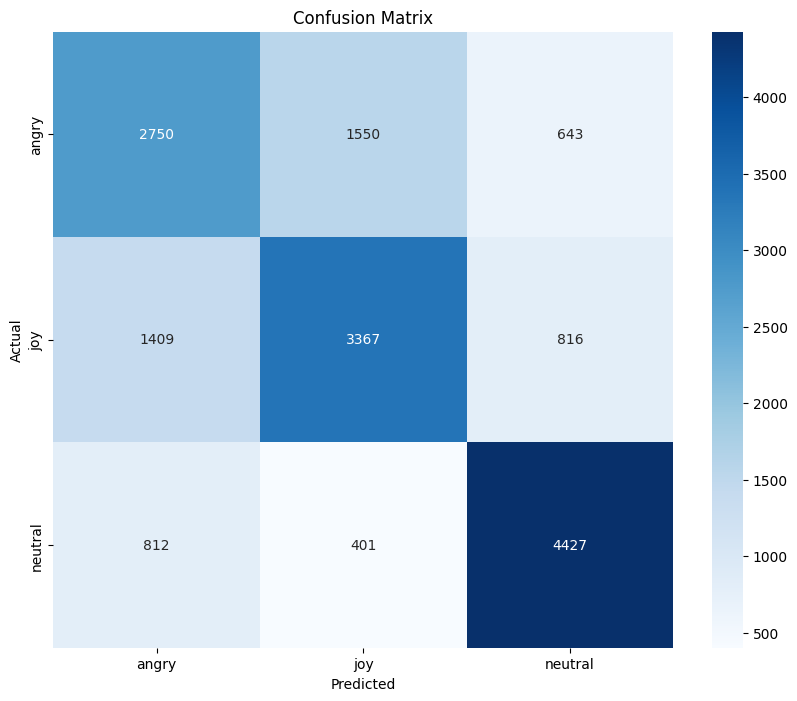

In [12]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def build_model_hbd(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Input(shape=(100, 62)))
    
    # Primera capa convolucional con hiperparámetros ajustables
    filters_1 = hp.Choice('filters_1', values=[16, 32, 64, 128])
    kernel_size_1 = hp.Int('kernel_size_1', min_value=2, max_value=5, step=1)
    dropout_1 = hp.Choice('dropout_1', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_1, kernel_size=kernel_size_1, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_1))
    
    # Segunda capa convolucional con hiperparámetros ajustables
    filters_2 = hp.Choice('filters_2', values=[16, 32, 64, 128])
    kernel_size_2 = hp.Int('kernel_size_2', min_value=2, max_value=5, step=1)
    dropout_2 = hp.Choice('dropout_2', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_2, kernel_size=kernel_size_2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_2))
    
    # Tercera capa convolucional con hiperparámetros ajustables
    filters_3 = hp.Choice('filters_3', values=[16, 32, 64, 128])
    kernel_size_3 = hp.Int('kernel_size_3', min_value=2, max_value=5, step=1)
    dropout_3 = hp.Choice('dropout_3', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Conv1D(filters=filters_3, kernel_size=kernel_size_3, padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(dropout_3))
    
    # Primera capa recurrente con hiperparámetros ajustables
    filters_4 = hp.Choice('filters_4', values=[16, 32, 64, 128])
    dropout_4 = hp.Choice('dropout_4', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(BatchNormalization())
    model.add(LSTM((filters_4), return_sequences=True))
    model.add(Dropout(dropout_4))
    
    # Segunda capa recurrente con hiperparámetros ajustables
    filters_5 = hp.Choice('filters_5', values=[16, 32, 64, 128])
    dropout_5 = hp.Choice('dropout_5', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(LSTM((filters_5)))
    model.add(Dropout(dropout_5))
    
    # Capa densa con hiperparámetros ajustables
    units_1 = hp.Choice('units_1', values=[16, 32, 64, 128, 256])
    dropout_6 = hp.Choice('dropout_6', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Dense(units_1, activation='relu'))
    model.add(keras.layers.Dropout(dropout_6))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Capa densa con hiperparámetros ajustables
    units_2 = hp.Choice('units_2', values=[16, 32, 64, 128, 256])
    dropout_7 = hp.Choice('dropout_7', values=[0.2, 0.4, 0.5, 0.7])
    
    model.add(keras.layers.Dense(units_2, activation='relu'))
    model.add(keras.layers.Dropout(dropout_7))
    model.add(keras.layers.Dense(3, activation='softmax'))
    
    # Optimizador con tasa de aprendizaje ajustable
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instanciar el tuner de optimización bayesiana
tuner = kt.BayesianOptimization(
    build_model_hbd,
    objective='val_loss',
    max_trials=70,  # Número máximo de intentos
    num_initial_points=10,  # Número de puntos iniciales aleatorios
    directory='optimizacion_bayesiana',
    project_name='hbd_optimization_tres_conv'
)

# Búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)],
    verbose=1
)

# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros encontrados:")
print(f"Filtros capa 1: {best_hps.get('filters_1')}")
print(f"Tamaño kernel capa 1: {best_hps.get('kernel_size_1')}")
print(f"Dropout capa 1: {best_hps.get('dropout_1')}")
print(f"Filtros capa 2: {best_hps.get('filters_2')}")
print(f"Tamaño kernel capa 2: {best_hps.get('kernel_size_2')}")
print(f"Dropout capa 2: {best_hps.get('dropout_2')}")
print(f"Filtros capa 3: {best_hps.get('filters_3')}")
print(f"Tamaño kernel capa 3: {best_hps.get('kernel_size_3')}")
print(f"Dropout capa 3: {best_hps.get('dropout_3')}")
print(f"Neuronas capa 4: {best_hps.get('filters_3')}")
print(f"Dropout capa 4: {best_hps.get('dropout_4')}")
print(f"Neuronas capa 5: {best_hps.get('filters_4')}")
print(f"Dropout capa 5: {best_hps.get('dropout_5')}")
print(f"Unidades capa densa 1: {best_hps.get('units_1')}")
print(f"Dropout capa densa 1: {best_hps.get('dropout_6')}")
print(f"Unidades capa densa 2: {best_hps.get('units_2')}")
print(f"Dropout capa densa 2: {best_hps.get('dropout_7')}")
print(f"Tasa de aprendizaje: {best_hps.get('learning_rate')}")

Reloading Tuner from optimizacion_bayesiana/hbd_optimization_tres_conv/tuner0.json
Mejores hiperparámetros encontrados:
Filtros capa 1: 16
Tamaño kernel capa 1: 2
Dropout capa 1: 0.2
Filtros capa 2: 16
Tamaño kernel capa 2: 5
Dropout capa 2: 0.4
Filtros capa 3: 16
Tamaño kernel capa 3: 2
Dropout capa 3: 0.7
Neuronas capa 4: 16
Dropout capa 4: 0.2
Neuronas capa 5: 32
Dropout capa 5: 0.7
Unidades capa densa 1: 64
Dropout capa densa 1: 0.5
Unidades capa densa 2: 128
Dropout capa densa 2: 0.7
Tasa de aprendizaje: 0.0001


/home/ricmarrom/miniconda3/envs/tfm_eeg/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


506/506 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

Accuracy: 0.6085

Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.57      0.51      4943
         joy       0.60      0.36      0.45      5592
     neutral       0.76      0.89      0.82      5640

    accuracy                           0.61     16175
   macro avg       0.60      0.61      0.59     16175
weighted avg       0.61      0.61      0.59     16175



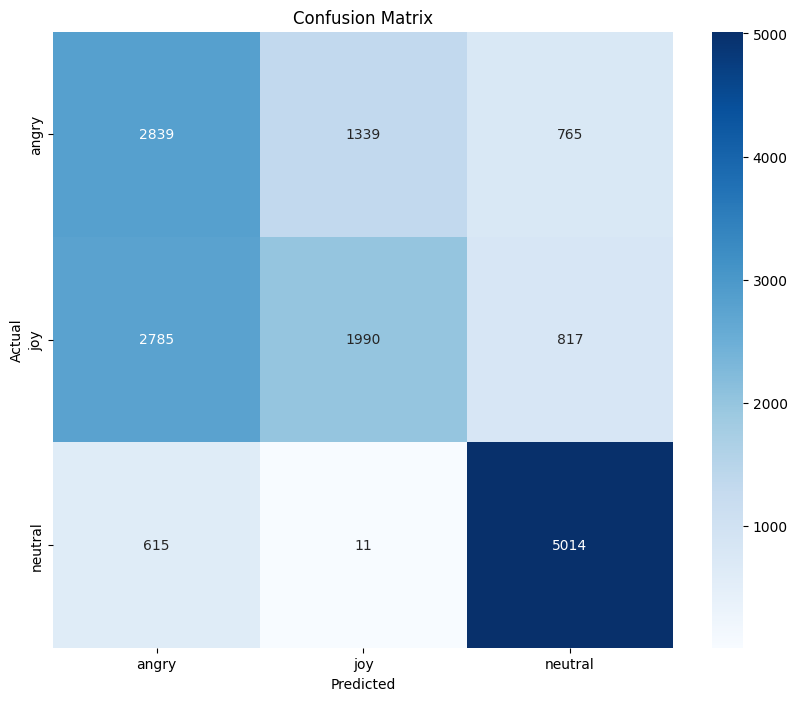

In [10]:
model = tuner.get_best_models()[0]
res = model.predict(X_test)
y_pred = np.argmax(res, axis = 1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))

p = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [63]:
model_hbd = models.Sequential([
    layers.Input(shape=(100, 62)),
    layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.4),
    #layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    #layers.MaxPooling1D(pool_size=2),
    #layers.Dropout(0.5),
    layers.LSTM((32), return_sequences=True),
    layers.Dropout(0.7),
    layers.LSTM((64)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    #layers.Dense(16, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(3, activation='softmax') 
])

model_hbd.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
optimizer=Adam(0.00157194665345342271),
metrics=["accuracy"])
model_hbd.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 100, 16)        │         2,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 100, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 50, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,619 (162.57 KB)

 Trainable params: 41,587 (162.45 KB)

 Non-trainable params: 32 (128.00 B)

In [64]:
model_checkpoint_callback = EarlyStopping(monitor='val_loss', mode='min', patience = 20, verbose = 1, min_delta=0.01, restore_best_weights=True)
history = model_hbd.fit(X_train, y_train, batch_size=32,epochs=1000, callbacks=[model_checkpoint_callback], validation_data=(X_valid, y_valid))
res = model_hbd.predict(X_test)
y_pred = np.argmax(res, axis = 1)
print(model_checkpoint_callback.best)                

Epoch 1/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.4649 - loss: 0.9815 - val_accuracy: 0.5179 - val_loss: 0.8736
Epoch 2/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6202 - loss: 0.7647 - val_accuracy: 0.5633 - val_loss: 0.8348
Epoch 3/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6629 - loss: 0.6890 - val_accuracy: 0.6136 - val_loss: 0.7934
Epoch 4/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7006 - loss: 0.6309 - val_accuracy: 0.6111 - val_loss: 0.8166
Epoch 5/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7176 - loss: 0.5997 - val_accuracy: 0.5671 - val_loss: 0.8990
Epoch 6/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7321 - loss: 0.5695 - val_accuracy: 0.6199 - val_loss: 0.8390
Epoch 7/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7540 - loss: 0.5334 - val_accuracy: 0.5950 - val_loss: 0.8551
Epoch 8/1000
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 

<h1> ##################################################
<h1> #####  PRUEBAS ESN  ##############################
<h1> ##################################################

In [216]:
n_classes = 3
labels = y_train  # Ejemplo de etiquetas
Y = np.eye(n_classes)[labels]

In [217]:
labels = y_test  # Ejemplo de etiquetas
real = np.eye(n_classes)[labels]

In [221]:
rpy.verbosity(0)

0

In [ ]:
def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    params = {
        'n_reservoir': trial.suggest_int('n_reservoir', 100, 500),
        'sr': trial.suggest_float('sr', 0.5, 1.5),
        'lr': trial.suggest_float('lr', 0.1, 0.9),
        'input_scaling': trial.suggest_float('input_scaling', 0.1, 1.0),
        'ridge': trial.suggest_float('ridge', 1e-8, 1e-5, log=True),
        'rc_connectivity': trial.suggest_float('rc_connectivity', 0.05, 0.3)
    }
    
    # Construcción del modelo
    reservoir = Reservoir(
        units=params['n_reservoir'],
        sr=params['sr'],
        lr=params['lr'],
        input_scaling=params['input_scaling'],
        rc_connectivity=params['rc_connectivity'],
        seed=42
    )
    
    readout = Ridge(ridge=params['ridge'], output_dim=3)
    esn = reservoir >> readout
    
    # Entrenamiento con validación
    try:
        esn.fit(X_train, Y, warmup=10)
        predictions = esn.run(X_test)
        accuracy = accuracy_score(np.argmax(real, axis=1), np.argmax(predictions, axis=1))
    except Exception as e:
        print(f"Error en trial {trial.number}: {str(e)}")
        accuracy = 0
    
    return accuracy

# Optimización
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# Optimización
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Mejores hiperparámetros
print("\nMejores hiperparámetros:")
best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value:.4f}")

# Entrenamiento final con mejores parámetros
best_reservoir = Reservoir(
    units=best_params['n_reservoir'],
    sr=best_params['sr'],
    lr=best_params['lr'],
    input_scaling=best_params['input_scaling'],
    rc_connectivity=best_params['rc_connectivity'],
    seed=42
)

best_readout = Ridge(ridge=best_params['ridge'])
best_esn = best_reservoir >> best_readout

best_esn.fit(X_train, Y, warmup=10)
predictions = best_esn.run(X_test)
accuracy_f = accuracy_score(np.argmax(real, axis=1), np.argmax(predictions, axis=1))

print(f"\nAccuracy final en test: {accuracy_f:.5f}")

[I 2025-05-13 00:42:25,681] A new study created in memory with name: no-name-816b288a-9824-455b-adef-20b464d2ba80
Best trial: 0. Best value: 0.349176:   2%|▏         | 1/50 [06:48<5:33:56, 408.91s/it]

[I 2025-05-13 00:49:14,588] Trial 0 finished with value: 0.34917613503874484 and parameters: {'n_reservoir': 250, 'sr': 1.4507143064099162, 'lr': 0.685595153449124, 'input_scaling': 0.6387926357773329, 'ridge': 2.938027938703534e-08, 'rc_connectivity': 0.08899863008405066}. Best is trial 0 with value: 0.34917613503874484.


Best trial: 0. Best value: 0.349176:   4%|▍         | 2/50 [13:00<5:09:31, 386.90s/it]

[I 2025-05-13 00:55:26,086] Trial 1 finished with value: 0.3446561072533989 and parameters: {'n_reservoir': 123, 'sr': 1.366176145774935, 'lr': 0.5808920093945671, 'input_scaling': 0.737265320016441, 'ridge': 1.1527987128232397e-08, 'rc_connectivity': 0.2924774630404986}. Best is trial 0 with value: 0.34917613503874484.


Best trial: 2. Best value: 0.360144:   6%|▌         | 3/50 [23:08<6:22:15, 488.00s/it]

[I 2025-05-13 01:05:34,363] Trial 2 finished with value: 0.36014422852710665 and parameters: {'n_reservoir': 433, 'sr': 0.7123391106782762, 'lr': 0.24545997376568052, 'input_scaling': 0.2650640588680905, 'ridge': 8.179499475211672e-08, 'rc_connectivity': 0.18118910790805948}. Best is trial 2 with value: 0.36014422852710665.


Best trial: 2. Best value: 0.360144:   8%|▊         | 4/50 [30:16<5:55:49, 464.12s/it]

[I 2025-05-13 01:12:41,906] Trial 3 finished with value: 0.3549823396144906 and parameters: {'n_reservoir': 273, 'sr': 0.7912291401980419, 'lr': 0.5894823157779036, 'input_scaling': 0.22554447458683766, 'ridge': 7.523742884534852e-08, 'rc_connectivity': 0.14159046082342291}. Best is trial 2 with value: 0.36014422852710665.


Best trial: 2. Best value: 0.360144:  10%|█         | 5/50 [37:05<5:33:21, 444.47s/it]

[I 2025-05-13 01:19:31,535] Trial 4 finished with value: 0.34744814179362754 and parameters: {'n_reservoir': 282, 'sr': 1.2851759613930136, 'lr': 0.25973902572668783, 'input_scaling': 0.5628109945722505, 'ridge': 5.987474910461391e-07, 'rc_connectivity': 0.061612603179999434}. Best is trial 2 with value: 0.36014422852710665.


Best trial: 2. Best value: 0.360144:  12%|█▏        | 6/50 [45:32<5:41:33, 465.75s/it]

[I 2025-05-13 01:27:58,598] Trial 5 finished with value: 0.35283093893360234 and parameters: {'n_reservoir': 343, 'sr': 0.6705241236872915, 'lr': 0.15204127438822362, 'input_scaling': 0.9539969835279999, 'ridge': 7.886714129990479e-06, 'rc_connectivity': 0.2520993370291153}. Best is trial 2 with value: 0.36014422852710665.


Best trial: 2. Best value: 0.360144:  14%|█▍        | 7/50 [52:12<5:18:21, 444.22s/it]

[I 2025-05-13 01:34:38,484] Trial 6 finished with value: 0.34739168746885807 and parameters: {'n_reservoir': 222, 'sr': 0.5976721140063839, 'lr': 0.6473864212097256, 'input_scaling': 0.4961372443656412, 'ridge': 2.3233503515390106e-08, 'rc_connectivity': 0.17379422752781754}. Best is trial 2 with value: 0.36014422852710665.


Best trial: 2. Best value: 0.360144:  16%|█▌        | 8/50 [58:14<4:52:35, 417.98s/it]

[I 2025-05-13 01:40:40,279] Trial 7 finished with value: 0.34891963604142273 and parameters: {'n_reservoir': 113, 'sr': 1.409320402078782, 'lr': 0.3070239852800135, 'input_scaling': 0.6962700559185838, 'ridge': 8.612579192594878e-08, 'rc_connectivity': 0.1800170052944527}. Best is trial 2 with value: 0.36014422852710665.


Best trial: 2. Best value: 0.360144:  18%|█▊        | 9/50 [1:06:27<5:01:31, 441.25s/it]

[I 2025-05-13 01:48:52,705] Trial 8 finished with value: 0.34640373678539255 and parameters: {'n_reservoir': 319, 'sr': 0.684854455525527, 'lr': 0.8756677022116469, 'input_scaling': 0.7976195410250031, 'ridge': 6.584106160121602e-06, 'rc_connectivity': 0.2737068376069122}. Best is trial 2 with value: 0.36014422852710665.


Best trial: 2. Best value: 0.360144:  20%|██        | 10/50 [1:13:56<4:55:46, 443.67s/it]

[I 2025-05-13 01:56:21,794] Trial 9 finished with value: 0.35890468791803815 and parameters: {'n_reservoir': 339, 'sr': 1.4218742350231168, 'lr': 0.1707940016415356, 'input_scaling': 0.27638457617723067, 'ridge': 1.366727291545617e-08, 'rc_connectivity': 0.1313325826908161}. Best is trial 2 with value: 0.36014422852710665.


[I 2025-05-13 02:07:33,542] Trial 10 finished with value: 0.37378162976272 and parameters: {'n_reservoir': 492, 'sr': 0.9733273214546685, 'lr': 0.3949830181768778, 'input_scaling': 0.11616568805333755, 'ridge': 6.570753427986461e-07, 'rc_connectivity': 0.2225617683922863}. Best is trial 10 with value: 0.37378162976272.


Best trial: 10. Best value: 0.373782:  22%|██▏       | 11/50 [1:29:17<5:16:33, 487.02s/it]


[W 2025-05-13 02:11:42,582] Trial 11 failed with parameters: {'n_reservoir': 495, 'sr': 0.9850975500820943, 'lr': 0.38722338500839976, 'input_scaling': 0.10339182502403145, 'ridge': 8.645086179670688e-07, 'rc_connectivity': 0.22428897458502367} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2767/2244626423.py", line 27, in objective
    esn.fit(X_train, Y, warmup=10)
  File "/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/reservoirpy/model.py", line 1128, in fit
    next_X += [_partial_fit_fn(x_seq=x_seq, y_seq=y_seq)]
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ricmarrom/miniconda3/envs/py312gpu/lib/python3.12/site-packages/reservoirpy/model.py", line 129, in run_and_partial_fit


KeyboardInterrupt: 

In [ ]:
print(accuracy_f)

In [ ]:
from reservoirpy.nodes import Reservoir, Ridge, Input

# Semilla para reproducibilidad
rpy.set_seed(42)

# Hiperparámetros
UNITS = 200  # Número de neuronas en el reservorio
SPECTRAL_RADIUS = 1.25  # Radio espectral
INPUT_SCALING = 0.5  # Escalado de entrada
LEAK_RATE = 0.3  # Tasa de fuga
RC_CONNECTIVITY = 0.1  # Densidad de la matriz interna del reservorio
INPUT_CONNECTIVITY = 0.2  # Densidad de la matriz de entrada
REGULARIZATION = 1e-8  # Coeficiente de regularización

# Crear los nodos
entrada = Input()
reservorio = Reservoir(
    units=UNITS,
    sr=SPECTRAL_RADIUS,
    input_scaling=INPUT_SCALING,
    lr=LEAK_RATE,
    rc_connectivity=RC_CONNECTIVITY,
    input_connectivity=INPUT_CONNECTIVITY,
    seed=42
)
readout = Ridge(ridge=REGULARIZATION, output_dim=3)

# Conectar los nodos para formar la ESN
esn = entrada >> reservorio >> readout

In [225]:
esn.fit(X_train, Y, warmup=10)

'Model-39': Model('Input-12', 'Reservoir-30', 'Ridge-28')

In [226]:
predictions = esn.run(X_train)

In [227]:
accuracy = accuracy_score(np.argmax(real, axis=1), np.argmax(predictions, axis=1))

In [228]:
print(accuracy)

0.38149311748410275


<h1> ##################################################
<h1> ###  Visualización de Resultados  ####################
<h1> ##################################################

In [65]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['angry', 'joy', 'neutral']))


Accuracy: 0.6142

Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.57      0.51      4943
         joy       0.57      0.52      0.55      5592
     neutral       0.86      0.74      0.80      5640

    accuracy                           0.61     16175
   macro avg       0.63      0.61      0.62     16175
weighted avg       0.64      0.61      0.62     16175



In [66]:
p = confusion_matrix(y_test, y_pred, labels=[0,1,2])

print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


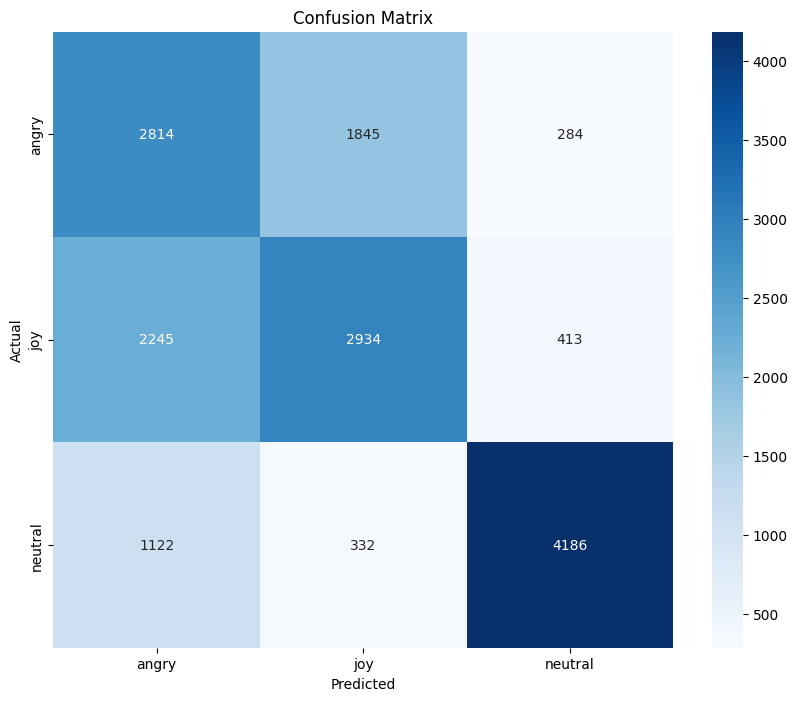

In [67]:
plt.figure(figsize=(10, 8))
sns.heatmap(p, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'joy', 'neutral'], yticklabels=['angry', 'joy', 'neutral'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Text(0.5, 1.0, 'Loss')

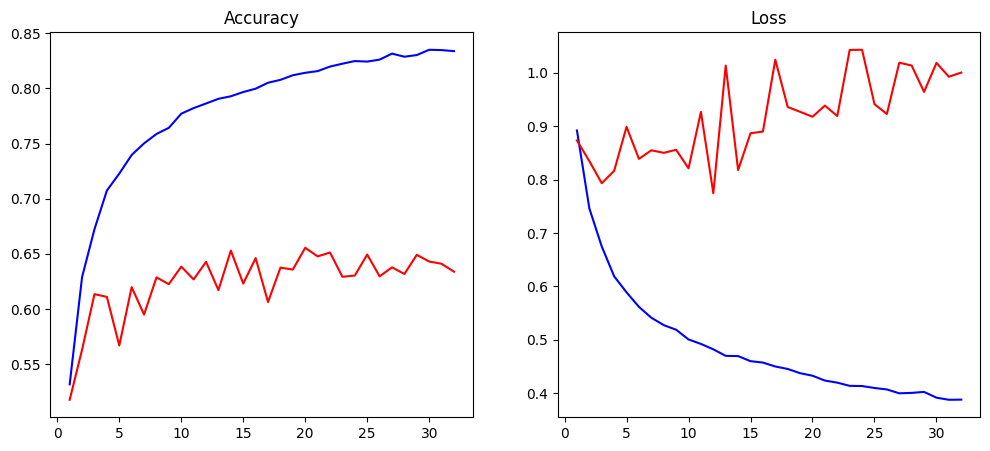

In [68]:
acc = history.history["accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["val_accuracy"]

x = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, "b", label="traning_acc")
plt.plot(x, val_accuracy, "r", label="traning_acc")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(x, loss, "b", label="traning_acc")
plt.plot(x, val_loss, "r", label="traning_acc")
plt.title("Loss")

<h1> ##################################################
<h1> #####  IA EXPLICATIVA  ##############################
<h1> ##################################################

In [23]:
y_train = np.expand_dims(y_train, axis=-1)
y_valid = np.expand_dims(y_valid, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [9]:
canales = ['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 
           'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 
           'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 
           'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 
           'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'CB1', 
           'O1', 'Oz', 'O2', 'CB2']

In [10]:
explainer = lime.lime_tabular.RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=canales,
                                                   mode="classification",
                                                   class_names=['Angry', 'Neutral', 'Joy'])

In [11]:
exp = explainer.explain_instance(X_test[100], model.predict, num_features=62, top_labels=2)
exp.show_in_notebook(show_table=True)
exp.as_list(label=2)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[('-9.83 < C3_t-47 <= -0.15', -0.00029693513358372667),
 ('-10.19 < F1_t-58 <= -0.45', -0.0002799208116954917),
 ('CB1_t-3 <= -11.77', -0.0002704270845159329),
 ('-13.62 < TP7_t-77 <= 0.42', -0.0002667783559947132),
 ('-0.36 < F8_t-44 <= 16.99', -0.00026608406672108903),
 ('CP5_t-28 <= -11.53', -0.0002656404360102961),
 ('P5_t-66 <= -11.38', -0.0002641244171569776),
 ('P3_t-10 <= -10.46', -0.00026337043221647547),
 ('PO6_t-36 <= -11.53', -0.00026252343613162676),
 ('-16.84 < FT7_t-40 <= 0.09', -0.0002611185936799746),
 ('O2_t-60 <= -11.48', -0.0002586722199481717),
 ('O2_t-24 <= -11.62', -0.00025849303804687684),
 ('P5_t-65 <= -11.32', -0.00025673330653263444),
 ('-13.56 < TP7_t-79 <= 0.51', -0.0002541897879721889),
 ('C2_t-73 <= -6.62', -0.0002534996158574545),
 ('-15.41 < AF3_t-87 <= -0.98', -0.00025337230841986346),
 ('PO3_t-44 <= -11.50', -0.00025303490087010715),
 ('0.27 < CP6_t-84 <= 10.64', -0.0002491516334467639),
 ('P7_t-23 <= -12.84', -0.0002491059808033966),
 ('-0.33 < FC4_t

In [150]:
exp = explainer.explain_instance(X_test[7], model.predict, num_features=62, top_labels=2)
exp.show_in_notebook(show_table=True)
exp.as_list()

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[('PO6_t-34 > 11.98', 0.0007522658292121368),
 ('F3_t-61 > 11.68', 0.0007394448132768811),
 ('0.06 < C5_t-4 <= 12.40', 0.0007258678962689292),
 ('F5_t-40 > 16.09', 0.0007200915407647407),
 ('0.75 < P1_t-30 <= 12.79', 0.0007163908186471369),
 ('-14.81 < F6_t-92 <= -0.42', 0.0007126320403444236),
 ('C2_t-4 <= -6.65', 0.0007121478506752713),
 ('C4_t-67 > 8.58', 0.0007062344918139889),
 ('POz_t-69 > 10.82', 0.0007022788705150751),
 ('CP1_t-32 > 7.39', 0.0006979712296792707),
 ('CP2_t-15 > 6.97', 0.0006863152605089462),
 ('-1.04 < AF4_t-31 <= 12.22', 0.0006780515040968422),
 ('-11.50 < O2_t-81 <= 0.51', 0.0006744231975869904),
 ('FC3_t-56 > 10.07', 0.0006625231712163819),
 ('CPz_t-51 > 2.35', 0.000651515458388866),
 ('0.69 < P3_t-67 <= 10.94', 0.0006476832772450527),
 ('0.60 < P2_t-26 <= 9.42', 0.0006468521117276255),
 ('-24.83 < F7_t-98 <= -1.07', 0.0006457377008759564),
 ('CPz_t-44 > 2.30', 0.0006424797543105908),
 ('0.21 < CP4_t-62 <= 9.30', 0.0006419720000786874),
 ('CP2_t-93 > 6.97', 0

In [164]:
exp = explainer.explain_instance(X_test[1878], model.predict, num_features=62, top_labels=2)
exp.show_in_notebook(show_table=True)
exp.as_list(label=0)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[('C1_t-91 > 6.74', 0.0031249283391771563),
 ('C1_t-11 > 6.77', 0.00305031193648555),
 ('-0.66 < F5_t-49 <= 16.45', 0.0029592723554001665),
 ('Cz_t-12 > 6.08', 0.002743482186926274),
 ('-10.34 < P6_t-66 <= 0.45', 0.0026796937858849026),
 ('-12.40 < PO7_t-29 <= 0.63', 0.002615078097639002),
 ('FC2_t-16 <= -8.55', 0.002524161753596288),
 ('PO7_t-48 <= -12.40', 0.0024925557959766345),
 ('CB1_t-46 <= -11.74', 0.002383673097778628),
 ('T8_t-30 <= -14.69', 0.002372756777966873),
 ('-16.69 < FT7_t-74 <= 0.21', 0.0023067568485596367),
 ('P7_t-49 <= -13.05', 0.0022647327191459617),
 ('P5_t-34 <= -11.18', 0.00225485072362394),
 ('-7.00 < CP2_t-34 <= 0.15', 0.0022365607849523694),
 ('PO6_t-75 <= -11.65', 0.002229548227887738),
 ('F1_t-18 <= -10.34', 0.002210219111244502),
 ('C3_t-57 > 9.60', 0.002142100012126234),
 ('C2_t-42 > 6.41', 0.002103243199986453),
 ('FC6_t-59 <= -12.13', 0.0020851636011444694),
 ('0.06 < C4_t-4 <= 8.61', 0.002043023820730068),
 ('-1.07 < AF3_t-84 <= 12.96', 0.00203802992

In [152]:
exp = explainer.explain_instance(X_test[8], model.predict, num_features=62, top_labels=2)
exp.show_in_notebook(show_table=True)
exp.as_list(label=2)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[('Fp2_t-48 <= -20.24', -0.0026551235703241886),
 ('CP3_t-3 > 8.91', -0.002299918732182238),
 ('-8.67 < FCz_t-24 <= -0.36', -0.0022954084830169156),
 ('P6_t-63 > 10.79', -0.0022131250513425923),
 ('P4_t-46 > 11.32', -0.002083582669218122),
 ('P8_t-36 > 12.31', -0.0019666605919283642),
 ('0.24 < FT7_t-18 <= 16.90', -0.0019495065825107683),
 ('TP7_t-79 > 14.19', -0.0019344206234906405),
 ('P2_t-65 > 9.42', -0.001873170502297465),
 ('P3_t-39 > 10.91', -0.0018539591138409782),
 ('CP4_t-80 > 9.27', -0.0018432039754877638),
 ('O1_t-12 > 11.81', -0.001769447705321308),
 ('-12.26 < C5_t-25 <= 0.12', -0.0017080190728355421),
 ('Pz_t-56 > 9.21', -0.0017061388564172805),
 ('PO6_t-27 > 11.98', -0.0016886386022345768),
 ('T8_t-11 > 15.17', -0.0016171024893253498),
 ('AF3_t-96 > 13.05', -0.0014991076957019081),
 ('Fz_t-46 <= -10.22', -0.0014890541997818927),
 ('PO6_t-0 > 12.07', -0.0014780501187709341),
 ('-12.79 < F3_t-21 <= -0.63', -0.001467342854193078),
 ('0.42 < T8_t-93 <= 15.14', -0.0014588140

In [26]:
from tqdm import tqdm
import pandas as pd

print(' Computing LSTM feature importance...')
COLS = canales            
# COMPUTE BASELINE (NO SHUFFLE)     
results = []
oof_preds = model.predict(X_valid, verbose=0).squeeze() 
baseline_mae = np.mean(np.abs( oof_preds-y_valid ))
results.append({'feature':'BASELINE','mae':baseline_mae})      

for k in tqdm(range(len(canales))):

    # SHUFFLE FEATURE K
    save_col = X_valid[:,:,k].copy()
    np.random.shuffle(X_valid[:,:,k])

    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = model.predict(X_valid, verbose=0).squeeze() 
    mae = np.mean(np.abs( oof_preds-y_valid ))
    results.append({'feature':COLS[k],'mae':mae})
    X_valid[:,:,k] = save_col

# DISPLAY LSTM FEATURE IMPORTANCE
print()
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,20))
plt.barh(np.arange(len(COLS)+1),df.mae)
plt.yticks(np.arange(len(COLS)+1),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(COLS)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
         label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
plt.xlabel(f'Fold OOF MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

 Computing LSTM feature importance...


ValueError: operands could not be broadcast together with shapes (14831,3) (14831,) 

In [20]:
X100 = shap.utils.sample(X_train, 100)
shap_explainer = shap.Explainer(model, X100, feature_names=canales)
shap_values = shap_explainer(X_test)

TypeError: 'numpy.ndarray' object is not callable